# Starbucks Capstone Project

_A Udacity Data Science Project_

## Project Overview

This dataset contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Problem Statement

The primary goal of this analysis is to understand the factors that influence customer spending at Starbucks. I will also investigate the relationship between gender and customer spending. I have summaried this into 4 main questions which I will aim to answer in this notebook:

1. Does gender correlate to how much someone spends at Starbucks?
2. How many customers viewed then completed offers? And how many customers completed offers without seeing them first?
3. Which offer type is the most likely to be completed after viewed?
4. What are the attributes that most contribute to a customer's likelihood of completing an offer after viewing it?

By addressing these questions, I aim to provide insights that can help Starbucks optimize their offers and marketing strategies to enhance customer engagement and increase revenue.

### Project Strategy

To address these research questions, first I will perform several analyses on the dataset. Firstly, we examined the relationship between gender and customer spending by conducting statistical tests and visualizing the distribution of spending amounts for different genders.

Next, we explored the number of people who viewed and completed offers, as well as those who completed offers without opening them first. We calculated relevant metrics and created visualizations to understand the offer engagement patterns.

We also investigated the completion rates of different offer types after being viewed. By analyzing the data, we determined which offer type has the highest likelihood of being completed after being viewed.

Lastly, we employed feature importance techniques, such as correlation analysis and machine learning models, to identify the attributes that have the most significant impact on customer spending habits.

By leveraging these analysis strategies, we aim to provide insights that can help Starbucks optimize their offers, personalize marketing campaigns, and enhance customer satisfaction.


## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer. A value of 118 represents a missing value.
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [179]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [89]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [90]:
profile.head() 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [91]:
transcript.head() 

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Data Cleaning

### Portfolio Data

In [92]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [93]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [94]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

The _'channels'_ column seems to store a list for each offer, where the list contains values for which medium it's sent to customers. The values will need to be extracted and split up into dummy columns.

In [95]:
# check for missing values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Steps for data cleaning:
- convert the column _'channels'_ into 4 different dummy channel columns on the basis of different types of channel, where 1 represents a true value and 0 represents false.
- convert the column _'offer_type'_ into 3 dummy columns on the basis of different types of offers, where 1 represents a true value and 0 represents false.
- rename the _'id'_ column name to _'offer_id'_.

In [96]:
portfolio_clean = portfolio.copy()
dummy_channels = pd.get_dummies(portfolio_clean['channels'].explode()).groupby(level=0).sum()
dummy_offertype = pd.get_dummies(portfolio['offer_type']).groupby(level=0).sum()

portfolio_clean = pd.concat([portfolio_clean, dummy_channels], axis=1)
portfolio_clean = pd.concat([portfolio_clean, dummy_offertype], axis=1)

portfolio_clean = portfolio_clean.drop(columns='channels')
portfolio_clean = portfolio_clean.rename(columns={'id':'offer_id'})
portfolio_clean.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


### Profile Data

In [97]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [98]:
# check the missing values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [99]:
# what percentage of income (and gender) data is missing?
round(100*profile['income'].isna().sum()/profile.shape[0],2)

12.79

There are 2175 missing values in both the _'gender'_ and the _'income'_ columns, approximately 12.8% of the rows in the table. We'll come back to this later to investigate what to do with these missing values.

In [100]:
# check the number of duplicated rows
profile.duplicated(subset=['id']).sum()

0

In [101]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Steps for data cleaning:
- convert the data type of _'became_member_on'_ column from into to datetime.
- change the -'id'_ column name to _'customer_id'_.
- extract the membership year and make into a new column.
- create a new column called _'customer_loyalty_days'_ to show how long the customer has been a member (in days).
- make dummy columns for membership year.
- make dummy columns for gender.

In [102]:
profile_clean = profile.copy()
profile_clean['membership_year'] = profile_clean['became_member_on'].astype(str).apply(lambda x: x[0:4])
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')

date_now = pd.to_datetime(datetime.datetime.now().date())
profile_clean['customer_loyalty_days'] = (date_now - profile_clean['became_member_on'])
profile_clean['customer_loyalty_days'] = profile_clean['customer_loyalty_days'].dt.days

gender_dummies = profile_clean['gender'].str.get_dummies().add_prefix('gender_')
year_joined_dummies = profile_clean['membership_year'].str.get_dummies().add_prefix('year_joined_')

profile_clean = pd.concat([profile_clean, gender_dummies, year_joined_dummies], axis=1)
profile_clean = profile_clean.rename(columns={'id':'customer_id'})
profile_clean.head()

,gender,age,customer_id,became_member_on,income,membership_year,customer_loyalty_days,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2319,0,0,0,0,0,0,0,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,2166,1,0,0,0,0,0,0,1,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,1804,0,0,0,0,0,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,2233,1,0,0,0,0,0,0,1,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,2146,0,0,0,0,0,0,0,1,0


In [103]:
profile_missing = profile_clean[profile_clean['income'].isna()]
profile_missing.isnull().sum()

gender                   2175
age                         0
customer_id                 0
became_member_on            0
income                   2175
membership_year             0
customer_loyalty_days       0
gender_F                    0
gender_M                    0
gender_O                    0
year_joined_2013            0
year_joined_2014            0
year_joined_2015            0
year_joined_2016            0
year_joined_2017            0
year_joined_2018            0
dtype: int64

It looks like all missing gender and income values are on the same rows. We'll explore the _'age'_ and _'became_member_on'_ columns for these rows.

In [104]:
profile_missing.describe()

,age,became_member_on,income,customer_loyalty_days,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
count,2175.0,2175,0.0,2175.000000,2175.0,2175.0,2175.0,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000
mean,118.0,2017-03-29 19:53:42.620689920,NaN,2273.171034,0.0,0.0,0.0,0.005517,0.013333,0.107126,0.230805,0.400000,0.243218
min,118.0,2013-08-02 00:00:00,NaN,1790.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118.0,2016-07-04 12:00:00,NaN,2002.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,118.0,2017-07-31 00:00:00,NaN,2150.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,118.0,2017-12-26 00:00:00,NaN,2541.500000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,118.0,2018-07-26 00:00:00,NaN,3609.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.0,NaN,NaN,350.201317,0.0,0.0,0.0,0.074090,0.114724,0.309345,0.421445,0.490011,0.429125


In [105]:
profile_clean[profile_clean['age'] == 118].count()

gender                      0
age                      2175
customer_id              2175
became_member_on         2175
income                      0
membership_year          2175
customer_loyalty_days    2175
gender_F                 2175
gender_M                 2175
gender_O                 2175
year_joined_2013         2175
year_joined_2014         2175
year_joined_2015         2175
year_joined_2016         2175
year_joined_2017         2175
year_joined_2018         2175
dtype: int64

The _'age'_ column only has values of 118 for the rows with missing gender and income values. This also means that the age is also missing for these customers so these rows will not be useful for demographic exploratory analysis as the only demographic information that we have is when they became a member. We will drop them later, after merging with other datasets as we'll need to know the customer_id number for ones to drop.

### Transcript Data

In [106]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [107]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [108]:
# check for missing values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [186]:
offer_status_dict = dict(transcript['event'].value_counts())
offer_status_dict

{'transaction': 138953,
 'offer received': 76277,
 'offer viewed': 57725,
 'offer completed': 33579}

In [191]:
# proportion of transactional data
100*offer_status_dict['transaction']/transcript.shape[0]

45.33037118231583

In [188]:
# proportion  of offers completed
100*offer_status_dict['offer completed']/offer_status_dict['offer received']

44.02244451145168

Most rows (45%) in the transcript dataset hold transactional data for customers. We can also see that only 44% of offers received were completed.

Now we'll look more into _'event'_ column in the dataset, which we know stores a dictionary.

In [110]:
transcript[transcript['event'] == 'offer received']['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
257882    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
257883    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
257884    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
257885    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
257886    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
Name: value, Length: 76277, dtype: object

In [111]:
transcript[transcript['event'] == 'offer viewed']['value']

12650     {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653     {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
                                ...                       
306441    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
306450    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
306483    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
306490    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
306507    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
Name: value, Length: 57725, dtype: object

In [112]:
transcript[transcript['event'] == 'transaction']['value']

12654     {'amount': 0.8300000000000001}
12657                  {'amount': 34.56}
12659                  {'amount': 13.23}
12670                  {'amount': 19.51}
12671                  {'amount': 18.97}
                       ...              
306529    {'amount': 1.5899999999999999}
306530                  {'amount': 9.53}
306531                  {'amount': 3.61}
306532    {'amount': 3.5300000000000002}
306533                  {'amount': 4.05}
Name: value, Length: 138953, dtype: object

In [113]:
transcript[transcript['event'] == 'offer completed']['value']

12658     {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672     {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679     {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692     {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697     {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
                                ...                        
306475    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
306497    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
306506    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306509    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306527    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
Name: value, Length: 33579, dtype: object

In [114]:
transcript[transcript['event'] == 'offer completed']['value'].iloc[0]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

We can see that for 'offer recieved' and 'offer viewed', the dictionary holds offer id information. When the event is 'transaction', the dictionary stores transaction amount data, and finally for 'offer completed', the dictionary has offer id again (although the space has been replaced with an underscore) and a reward value. The values in these dictionaries will need to be extracted and stored in separate columns depending on the dictionary key.

Steps for data cleaning:
- change the _'person'_ column name to _'customer_id'_.
- convert the column _'event'_ into 4 different dummy columns on the basis of different types of event.
- convert the column _'values'_ into 3 different columns which hold the dictionary values.

In [115]:
transcript_clean = transcript.copy()

transcript_clean = transcript_clean.rename(columns={'person':'customer_id'})
transcript_clean['event'] = transcript_clean['event'].str.replace(' ', '-')
dummy = pd.get_dummies(transcript_clean['event'])
dummy.replace({False: 0, True: 1}, inplace=True)

transcript_clean = pd.concat([transcript_clean, dummy], axis=1)
transcript_clean.head()

,customer_id,event,value,time,offer-completed,offer-received,offer-viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [116]:
def offer_dict(value):
    if 'offer_id' in value:
        return value['offer_id']
    if 'offer id' in value:
        return value['offer id']
    else:
        return np.NaN

transcript_clean['offer_id'] = transcript_clean['value'].map(offer_dict)

In [117]:
def amount_dict(value):
    if 'amount' in value:
        return value['amount']
    else:
        return np.NaN
    
transcript_clean['amount'] = transcript_clean['value'].map(amount_dict)

In [118]:
def reward_dict(value):
    if 'reward' in value:
        return value['reward']
    else:
        return np.NaN
    
transcript_clean['reward'] = transcript_clean['value'].map(reward_dict)

In [119]:
transcript_clean.drop(columns=['value'], inplace=True)

In [120]:
transcript_clean.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### Merge data

- Join all three cleaned datasets together on customer id and ofer id.

In [121]:
temp_merge = pd.merge(transcript_clean, profile_clean, on='customer_id', how='left')
temp_merge.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,reward,...,customer_loyalty_days,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,...,2233,1,0,0,0,0,0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,...,2146,0,0,0,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,...,1881,0,1,0,0,0,0,0,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,...,2094,0,0,0,0,0,0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,...,2087,0,0,0,0,0,0,0,1,0


In [122]:
df_merge = pd.merge(temp_merge, portfolio_clean, on='offer_id', how='left')
df_merge.sort_values(by = ['customer_id', 'time'], inplace=True)
df_merge.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,reward_x,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
55972,0009655768c64bdeb2e877511632db8f,offer-received,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,...,0.0,3.0,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0
77705,0009655768c64bdeb2e877511632db8f,offer-viewed,192,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,...,0.0,3.0,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,0,0,0,1,NaN,22.16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer-received,336,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,...,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0
139992,0009655768c64bdeb2e877511632db8f,offer-viewed,372,0,0,1,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,...,0.0,4.0,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [123]:
df_merge.shape

(306534, 36)

In [124]:
df_merge.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'reward_x',
       'gender', 'age', 'became_member_on', 'income', 'membership_year',
       'customer_loyalty_days', 'gender_F', 'gender_M', 'gender_O',
       'year_joined_2013', 'year_joined_2014', 'year_joined_2015',
       'year_joined_2016', 'year_joined_2017', 'year_joined_2018', 'reward_y',
       'difficulty', 'duration', 'offer_type', 'email', 'mobile', 'social',
       'web', 'bogo', 'discount', 'informational'],
      dtype='object')

In [125]:
# going back to those 2175 customers with missing age, gender and income data
profile_missing = df_merge[df_merge['income'].isna()]
len(profile_missing.customer_id.value_counts().index)

# now that we have those people matched by their customer ids, we can drop the rows
df_merge.dropna(subset=['income'], inplace=True)

## Exploratory Data Analysis

### Customer Demographics

#### Age Distribution

In [126]:
# dropping the 2175 rows with NA values from the cleaned profile table to use for visualisations
profile_clean.dropna(subset=['income'], inplace=True)

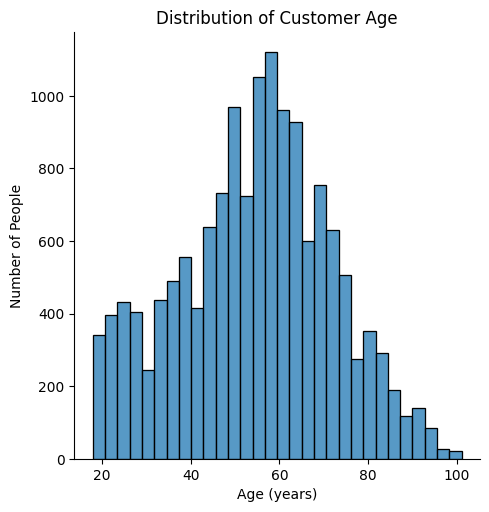

In [127]:
ax = sns.displot(profile_clean, x='age', bins=30)
ax.set(title='Distribution of Customer Age', xlabel='Age (years)', ylabel='Number of People');

In [128]:
print('Mean age of customers: ', profile_clean['age'].mean())
print('Median age of customers: ', profile_clean['age'].median())
# left skewed

Mean age of customers:  54.39352445193929
Median age of customers:  55.0


The distribution is slightly left skewed since the median is larger than the mean, but overall we can see that the majority of customers are 50-70 years old, which is older than I was expecting it to be. 

In [196]:
profile_clean.groupby('gender')['age'].mean()

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64

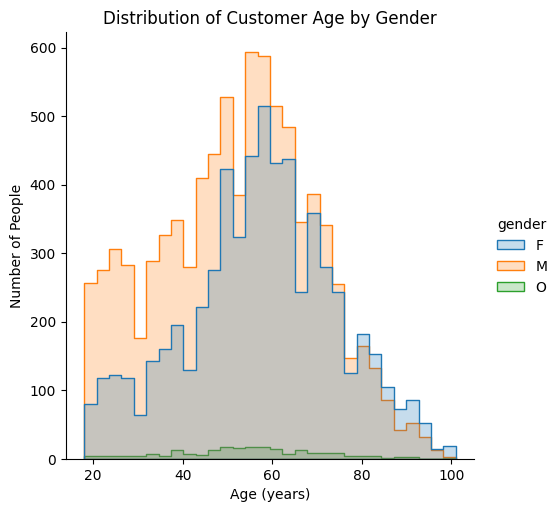

In [129]:
ax = sns.displot(profile_clean, x='age', hue='gender', element='step', bins=30)
ax.set(title='Distribution of Customer Age by Gender', xlabel='Age (years)', ylabel='Number of People');

The graph above shows the age distribution split by gender, where we can clearly see that there are a lot more males aged 20-40 than females, especially between 20-30 where it seems almost double the number of female customers. From approxiamtely 70 years old onwards the distribution between males and females appears pretty even. The mean age for females is 57 whereas for males it is 52, clearly showing that the younger generations on the app are more likely to be male.

#### Gender Distribution

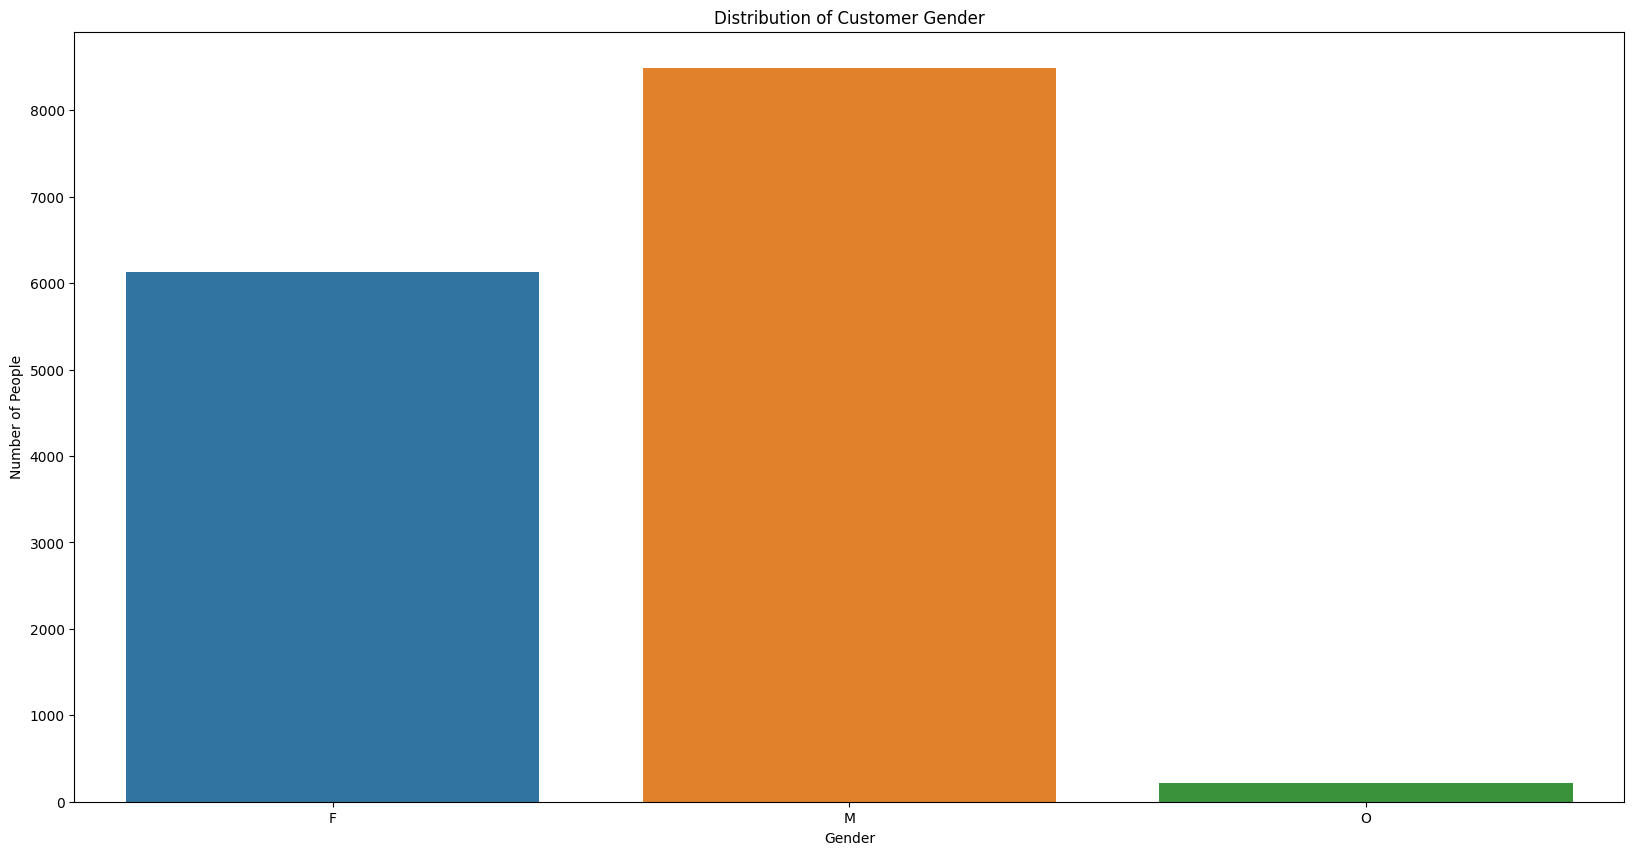

In [130]:
ax = sns.countplot(profile_clean, x='gender')
ax.set(title='Distribution of Customer Gender', xlabel='Gender', ylabel='Number of People');

In [131]:
gender_props = pd.DataFrame(profile_clean['gender'].value_counts())
gender_props['proportion'] = gender_props['count']/profile_clean.shape[0]
gender_props

,count,proportion
gender,,
M,8484,0.572277
F,6129,0.413423
O,212,0.014300


57% of the customer base in the datasets are male, with 41% female and approximately 200 people identifying as 'Other'.

#### Income Distribtuion

In [132]:
print('Mean income of customers: ', profile_clean['income'].mean())
print('Median income of customers: ', profile_clean['income'].median())
# right skewed

Mean income of customers:  65404.9915682968
Median income of customers:  64000.0


In terms of the income distribution of the customers, we see that it is slightly right skewed as this time the median is less than the mean.

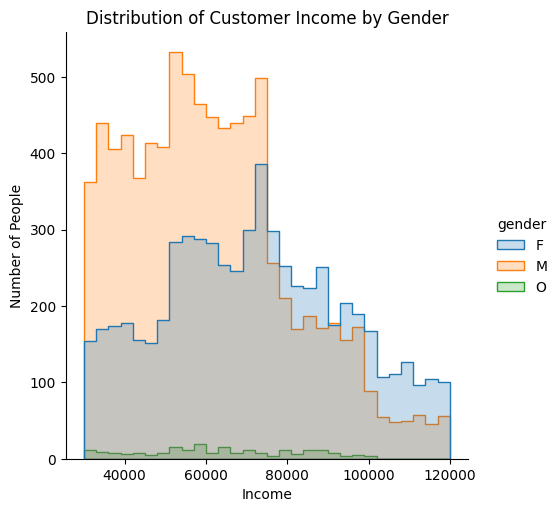

In [133]:
ax = sns.displot(profile_clean, x='income', hue='gender', element='step', bins=30)
ax.set(title='Distribution of Customer Income by Gender', xlabel='Income', ylabel='Number of People');

In [192]:
profile_clean.groupby('gender')['income'].mean()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

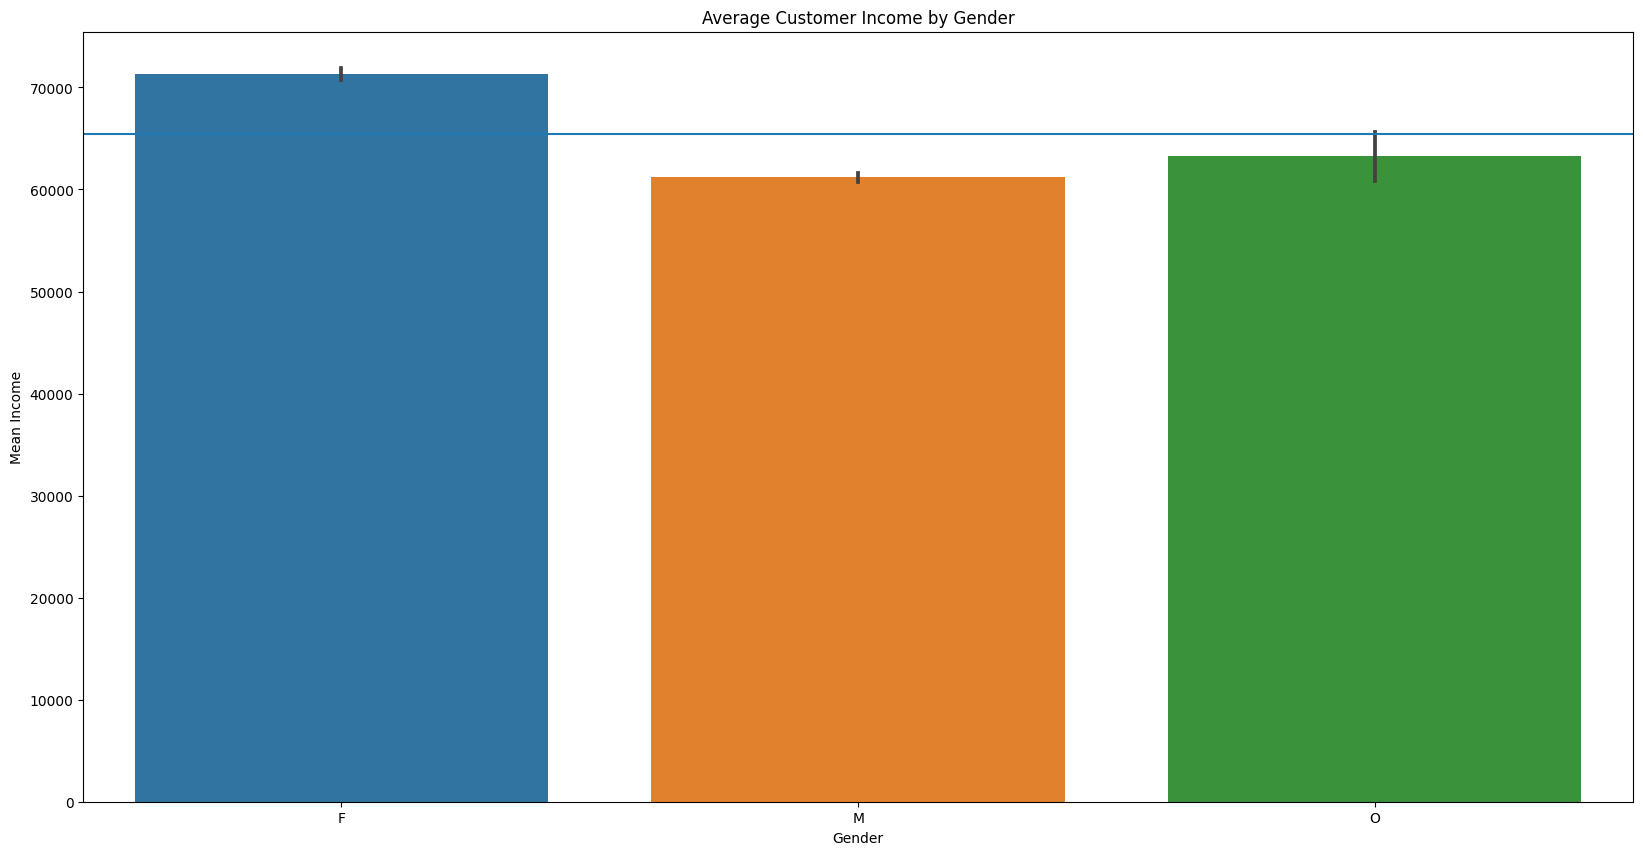

In [134]:
ax = sns.barplot(data=profile_clean, x="gender", y="income")
ax.axhline(y=profile_clean['income'].mean());
ax.set(title='Average Customer Income by Gender', xlabel='Gender', ylabel='Mean Income');

The charts above show that, on average, females earn significantly higher than males and other gender of the customers. The blue line in the second chart represents the average income for the whole of the dataset.

The first graph shows an interesting trend in that, for females, the income distribution follows more closely to a normal bell curve than for males. For males, the bulk of customers seem to be earning 75,000 or less, which is interesting as we saw earlier that the younger generations are more likely to be male, implying that we possibly have a split of younger, low-income males on the app and older, high-income females. The income distribution does make sense in that you would expect people who earn less money would be more likely to download and use the app, and consequentially be more likely to utilise drinks offers - hence why we would see more males on the app than females in the low-income range.

### Offer Type Analysis

Finally, we will conduct some exploratory analysis on the offers that were sent to customers in order to understand which offer types were the best recieved, and by which demographic.

In [199]:
channel_count = pd.DataFrame(portfolio_clean[['email', 'mobile', 'social', 'web']].sum()).reset_index(names='channel').rename(columns={0:'count'})
type_count = pd.DataFrame(portfolio_clean[['bogo', 'discount', 'informational']].sum()).reset_index(names='offer_type').rename(columns={0:'count'})
channel_count

,channel,count
0,email,10
1,mobile,9
2,social,6
3,web,8


Email and mobile channels of communication were the most common, and web was the least common. All offers were communicated by email.

In [136]:
type_count

,offer_type,count
0,bogo,4
1,discount,4
2,informational,2


In [197]:
test = pd.DataFrame(portfolio_clean[['offer_type','email', 'mobile', 'social', 'web']].groupby('offer_type').sum().reset_index())
test

,offer_type,email,mobile,social,web
0,bogo,4,4,3,3
1,discount,4,3,2,4
2,informational,2,2,1,1


Discount offers were more common by web or email channels of communication, whereas bogo and informational offers were more common by email and mobile channels.

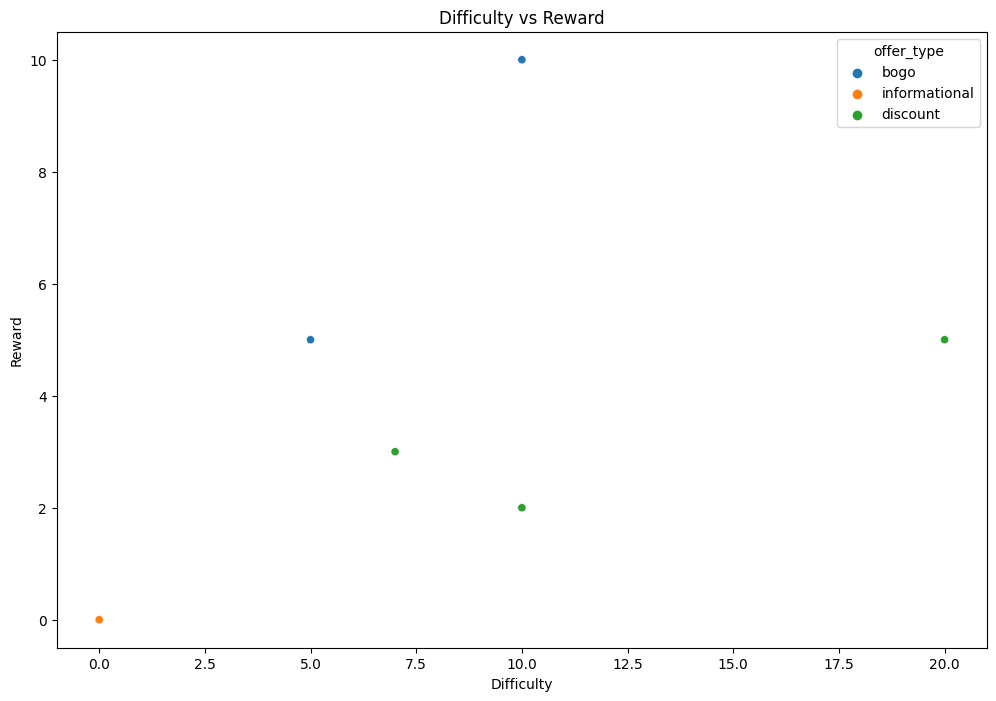

In [138]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(portfolio_clean, x='difficulty', y='reward', hue='offer_type')
ax.set(title='Difficulty vs Reward', xlabel='Difficulty', ylabel='Reward');

Looking at a scattergraph of difficulty (how much a customer has to spend to complete an offer) against reward (how much a customer gets after completing the offer), we can see that discount offers seemed to have less reward for the difficulty, whereas bogo offers had, of course, the same reward for difficulty which would make them more attractive to customers.

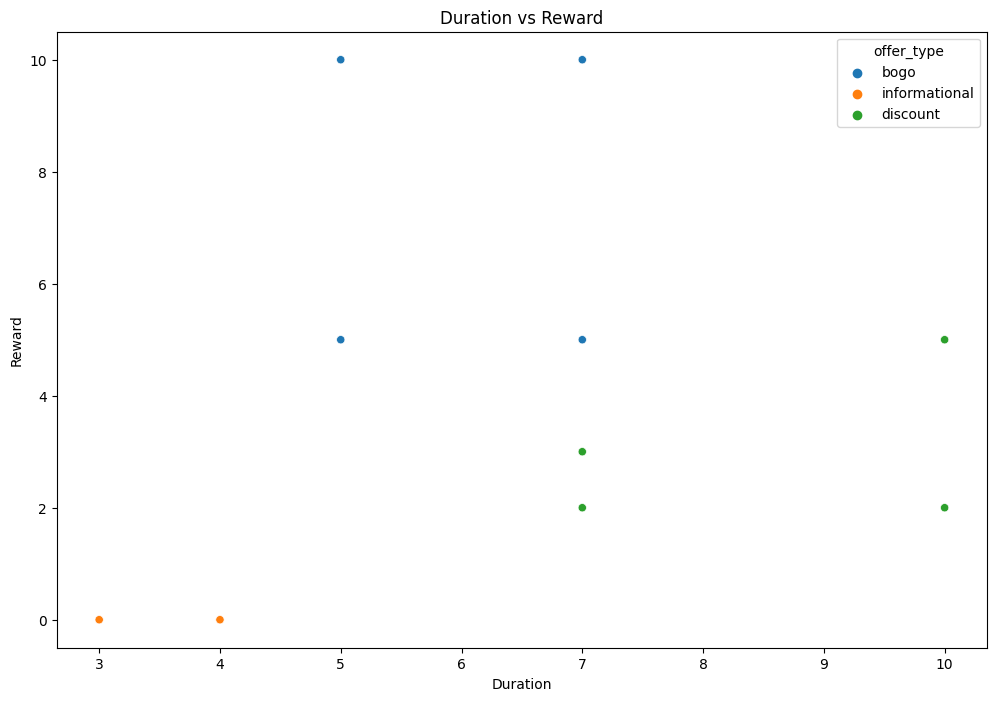

In [139]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(portfolio_clean, x='duration', y='reward', hue='offer_type')
ax.set(title='Duration vs Reward', xlabel='Duration', ylabel='Reward');

This scattergraph shows that ser see a cluster of discount offers in the bottom right corner implying that they lasted for a longer time than bogo offers but had less reward.
In comparison, bogo offers were shorter than discount offers and had more reward.

In [140]:
df_merge[df_merge['offer-received'] == 1][['email', 'mobile', 'social', 'web']].sum()

email     66501.0
mobile    59775.0
social    39802.0
web       53175.0
dtype: float64

Out of the offers that were sent to customers, we can see that most common channel of communication was by email, then web, then mobile and finally social being the least common.

In [141]:
df_merge[df_merge['offer-received'] == 1][['bogo', 'discount', 'informational']].sum()

bogo             26537.0
discount         26664.0
informational    13300.0
dtype: float64

Looking at the offers that were receievd by customers, there were slightly more discount offers sent than bogo offers, although the split is fairly even. The number of informational offers sent, in comparison, was approximately half that of bogo or discount offers.

### Transaction/Gender Analysis

In [142]:
transaction_df = df_merge[df_merge['transaction'] == 1]

transaction_df_F = transaction_df[transaction_df['gender_F'] == 1]
transaction_df_M = transaction_df[transaction_df['gender_M'] == 1]
transaction_df_O = transaction_df[transaction_df['gender_O'] == 1]

In [143]:
transaction_gender_df = pd.DataFrame(transaction_df_F['amount'].describe()).rename(columns={'amount':'Amount_F'})
transaction_gender_df['Amount_M'] = list(transaction_df_M['amount'].describe())
transaction_gender_df['Amount_O'] = list(transaction_df_O['amount'].describe())

transaction_gender_df['Income_F'] = list(transaction_df_F['income'].describe())
transaction_gender_df['Income_M'] = list(transaction_df_M['income'].describe())
transaction_gender_df['Income_O'] = list(transaction_df_O['income'].describe())
transaction_gender_df

,Amount_F,Amount_M,Amount_O,Income_F,Income_M,Income_O
count,49382.000000,72794.000000,1781.000000,49382.000000,72794.000000,1781.000000
mean,17.490077,11.606600,14.798731,66813.960552,58491.317966,61039.865244
std,35.342611,28.964542,25.748149,21965.016643,19048.170156,19009.521115
min,0.050000,0.050000,0.050000,30000.000000,30000.000000,30000.000000
25%,7.970000,2.570000,7.010000,51000.000000,43000.000000,47000.000000
50%,15.000000,7.050000,13.300000,65000.000000,56000.000000,60000.000000
75%,22.120000,16.220000,19.290000,82000.000000,70000.000000,74000.000000
max,1062.280000,977.780000,713.120000,120000.000000,120000.000000,100000.000000


The table above gives more detailed descriptive statistics on the transactional amount spent and income separated by gender. It shows that women clearly spend more than men do, with a far higher mean ($17.50 vs $11.61) and standard deviation, despite men seemingly purchasing drinks more often (as seen by count - 72794 vs 49382). The biggest disparity we see is in income. Females were seen to have a higher mean and 25/50/70 percentage quantile shows that the average female customer earns more than the average male customer.

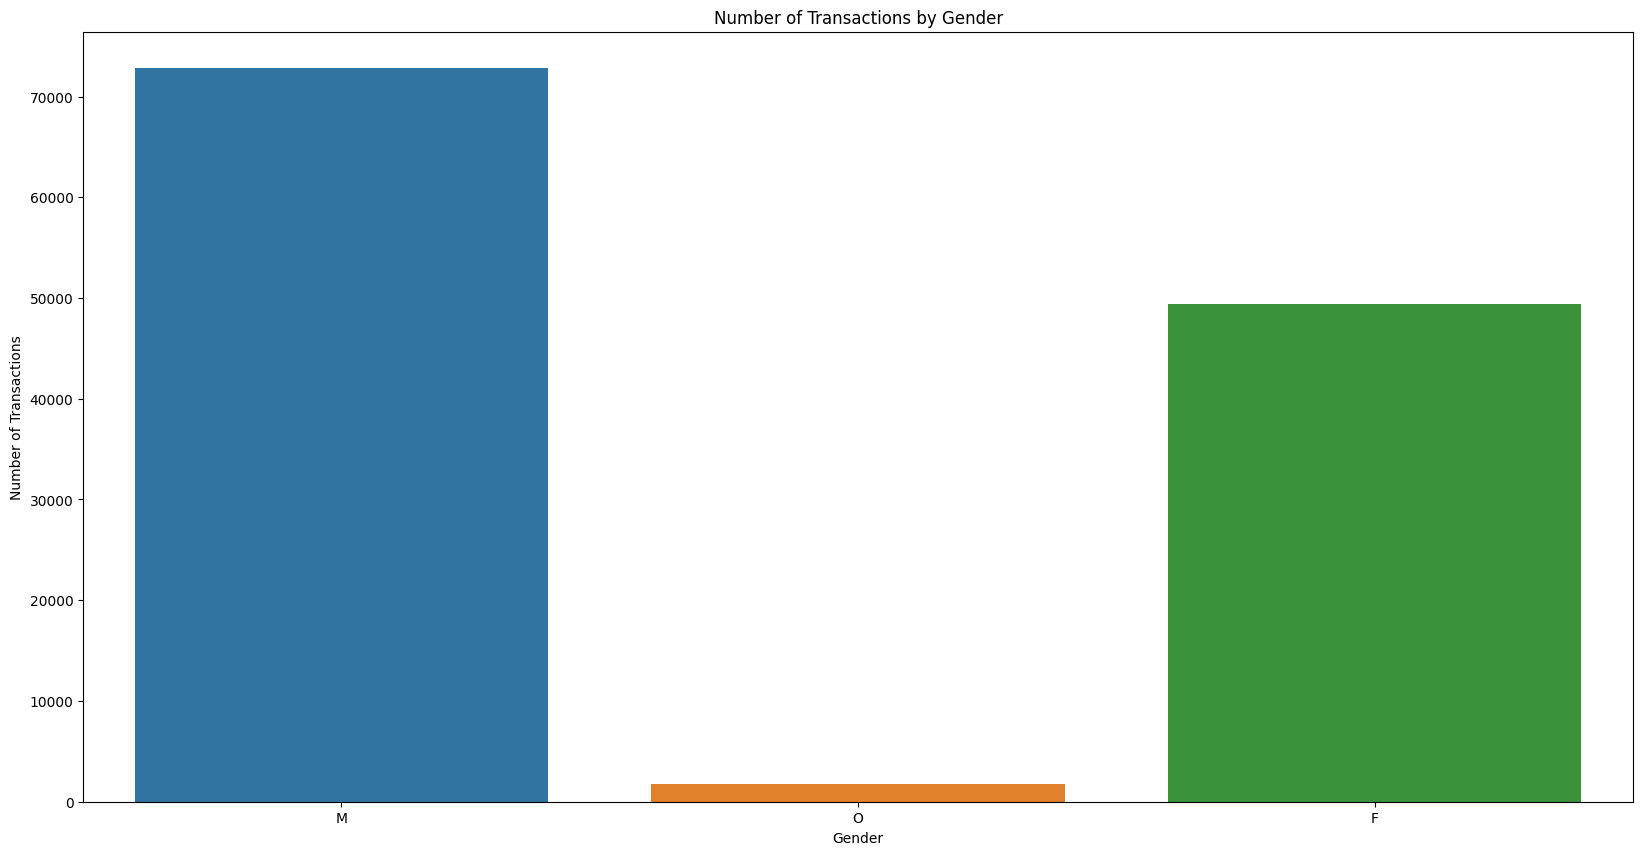

In [144]:
ax = sns.countplot(transaction_df, x='gender')
ax.set(title='Number of Transactions by Gender', xlabel='Gender', ylabel='Number of Transactions');

In [145]:
print('Average number of transactions per female customer:', transaction_df_F['amount'].count()/transaction_df_F['customer_id'].nunique())
print('Average number of transactions per male customer:', transaction_df_M['amount'].count()/transaction_df_M['customer_id'].nunique())
print('Average number of transactions per other customer:', transaction_df_O['amount'].count()/transaction_df_O['customer_id'].nunique())

Average number of transactions per female customer: 8.239946604371767
Average number of transactions per male customer: 8.775647980711272
Average number of transactions per other customer: 8.730392156862745


Although the count vaulue for the number of total transactions was far higher for males than females, the average number of transactions per customer in each gendered dataset is actually roughly the same, albeit slightly higher for males, therefore we can amend our initial observation and say that men do not spend more often than women.

In [146]:
transaction_amount = transaction_df[['customer_id', 'amount']].groupby(['customer_id']).sum(['amount']).reset_index()
transaction_count = transaction_df[['customer_id', 'amount']].groupby(['customer_id']).count().reset_index().rename(columns={'amount':'count'})

transaction_plot_df = pd.merge(transaction_amount, transaction_count, on='customer_id', how='left')
transaction_plot_df = pd.merge(transaction_plot_df, profile_clean[['customer_id','gender']], on='customer_id', how='left')
transaction_plot_df

,customer_id,amount,count,gender
0,0009655768c64bdeb2e877511632db8f,127.60,8,M
1,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,O
2,0020c2b971eb4e9188eac86d93036a77,196.86,8,F
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,F
4,003d66b6608740288d6cc97a6903f4f0,48.34,18,F
...,...,...,...,...
14487,fff3ba4757bd42088c044ca26d73817a,580.98,11,F
14488,fff7576017104bcc8677a8d63322b5e1,29.94,6,M
14489,fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5,M
14490,fffad4f4828548d1b5583907f2e9906b,88.83,12,M


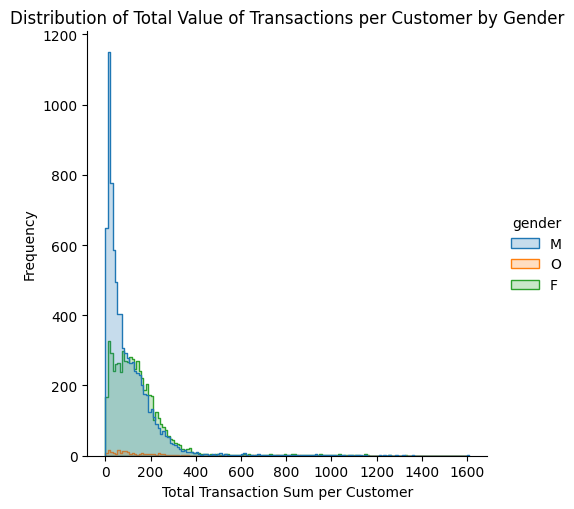

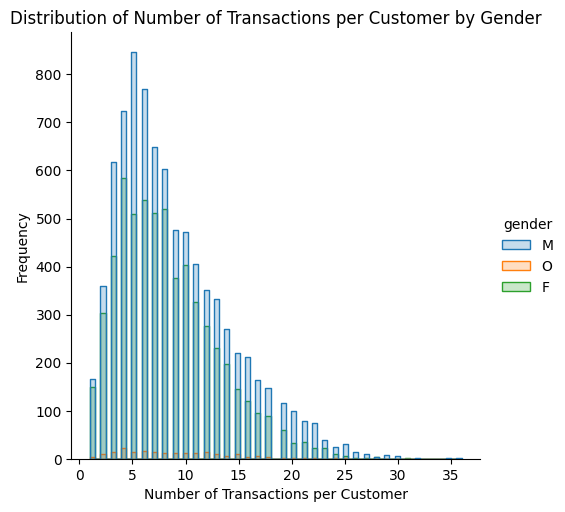

In [147]:
sns.displot(transaction_plot_df, x="amount", hue='gender', element='step').set(title='Distribution of Total Value of Transactions per Customer by Gender', xlabel='Total Transaction Sum per Customer', ylabel='Frequency')
sns.displot(transaction_plot_df, x="count", hue='gender', element='step').set(title='Distribution of Number of Transactions per Customer by Gender', xlabel='Number of Transactions per Customer', ylabel='Frequency')

The two plots above further back up our observations so far. The first plot, showing total value of transactions, shows that between $0-100 total value, there is a sharp spike in the male customer base. Above $100, the distribution is fairly even between males and females. This means that the far higher number of men that spend in total between $0-100 would bring the average total transactional amount lower than that of females. The second plot shows that the peaks and the spread of data about them are roughly the same for both males and females. Across the board there are higher counts of men for each number of transactions which simply show the larger male customer base.

*This answers our first question on the influence of gender on purchases. Women on average spend more at Starbucks then men do, with an average difference of about $6 per purchase. The customer base on the Starbucks app is predominately male, although these males on average earn less than the average female spender. The number of transactions between males and females is approximately the same.*

### Completion Trails Analysis

#### Offers Completed in General

In [148]:
offer_compl_df = df_merge[df_merge['offer-completed'] == 1].groupby(['offer_id']).count()[['customer_id']].reset_index().rename(columns={'customer_id':'count'})
offer_compl_df = pd.merge(offer_compl_df, portfolio_clean[['offer_id','bogo','discount','informational']], on='offer_id', how='left').sort_values(by='count', ascending=False)
offer_compl_df

,offer_id,count,bogo,discount,informational
7,fafdcd668e3743c1bb461111dcafc2a4,5003,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4886,0,1,0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,4188,1,0,0
6,f19421c1d4aa40978ebb69ca19b0e20d,4103,1,0,0
2,2906b810c7d4411798c6938adc9daaa5,3911,0,1,0
5,ae264e3637204a6fb9bb56bc8210ddfd,3657,1,0,0
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3386,0,1,0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,3310,1,0,0


In [149]:
print('Number of completed BOGO offers:',offer_compl_df[offer_compl_df['bogo']==1]['count'].sum())
print('Number of completed discount offers:',offer_compl_df[offer_compl_df['discount']==1]['count'].sum())
print('Number of completed informational offers:',offer_compl_df[offer_compl_df['informational']==1]['count'].sum())

Number of completed BOGO offers: 15258
Number of completed discount offers: 17186
Number of completed informational offers: 0


The most common offers to be completed by customers were discount offers. No informational offers were completed, probably because there is no difficulty or reward and the current dataset doesn't capture information about what drink was featured on the information offer and what drinks the customer purchased with each transaction. If this data was captured we'd be able to see when customers bought a drink that was featured in an informational offer.

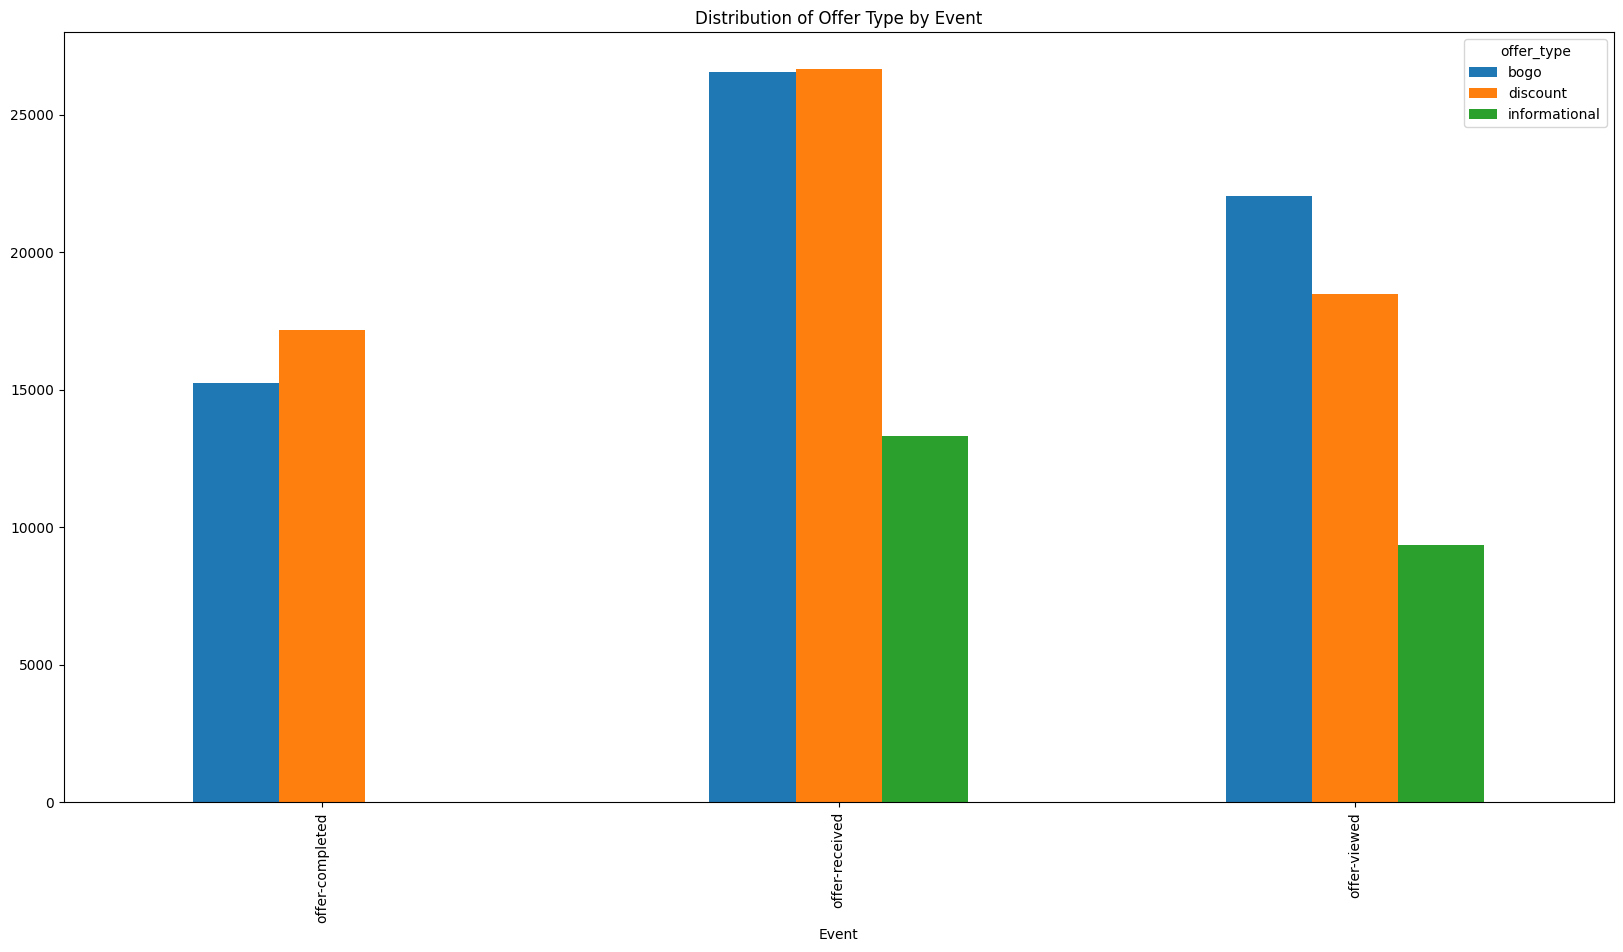

In [150]:
df_merge.groupby(['event', 'offer_type']).size().unstack().plot(kind='bar', stacked=False)
plt.title('Distribution of Offer Type by Event')
plt.xlabel('Event')
plt.show()

From the above chart, it can be seen that customers mostly received bogo and discount offers however, they were more likely to view the bogo offers. We already know that all offers are communicated via email, but bogo offers are more common via mobile and social, whereas discount offers were more common on the web. Even though customers viewed more bogo offers, offers thay mostly likely to complete discount offers, perhaps because the duration of these offers was on average longer, which allowed customers more time to spend the necessary amount.

In [210]:
transcript_clean

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0,0,0,1,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0,0,0,1,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,0,0,0,1,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0,0,0,1,NaN,3.53,NaN


#### Offers Completed after Viewing

In [152]:
transcript_portfolio = pd.merge(transcript_clean, portfolio_clean, on='offer_id', how='left')
transcript_by_group = transcript_portfolio.groupby(['customer_id', 'offer_id'])

As we know, it's possible for customers to complete an offer without having viewed it perviously, therefore it's not enough for us to just look at the totals for each offer status (received, viewed, completed) as we did previously. Below, I have created a new column called _'status'_ which has four possible values:
- 'completed_after_viewed': the ideal completion trail that we want to observe where the order of statuses is first received, then viewed, then completed.
- 'completed_before_viewed': the misleading completion trail where the order of statuses is received, then completed, then viewed.
- 'not_viewed_but_completed': another misleading completion trail where customers only received and completed the offer without ever viewing it.
- 'not_completed': either the customer received and viewed the offer, or just receieved it. There is no completion of the offer.

In [153]:
%%time

completion_details = [];

for pair, g in transcript_by_group:
    record = {}
    event = list(g['event'])
    
    if all(item in event for item in ['offer-received', 'offer-viewed', 'offer-completed']):
        if event.index('offer-viewed') < event.index('offer-completed'):
            record['status'] = 'completed_after_viewed';
        else:
            record['status'] = 'completed_before_viewed';
    elif all(item in event for item in ['offer-received', 'offer-completed']) and ('offer-viewed' not in event):
        record['status'] = 'not_viewed_but_completed';
    else:
        record['status'] = 'not_completed';

    person_id, offer_id = g['customer_id'].iloc[0], g['offer_id'].iloc[0];
    record['customer_id'], record['offer_id'] = person_id, offer_id;

    completion_details.append(record);

completion_details_df = pd.DataFrame(completion_details)

CPU times: total: 8.12 s
Wall time: 17.2 s


In [154]:
# the count and proportion of offers that are in each status category
status_df = pd.DataFrame(completion_details_df['status'].value_counts()).reset_index()
status_df['proportion'] = status_df['count']/completion_details_df.shape[0]
status_df

,status,count,proportion
0,not_completed,34292,0.541840
1,completed_after_viewed,20752,0.327898
2,not_viewed_but_completed,4536,0.071672
3,completed_before_viewed,3708,0.058589


In [220]:
# the number of customers that have at least one offer for each offer status
completion_details_df.groupby('status')['customer_id'].nunique()

status
completed_after_viewed      11568
completed_before_viewed      3233
not_completed               14674
not_viewed_but_completed     3850
Name: customer_id, dtype: int64

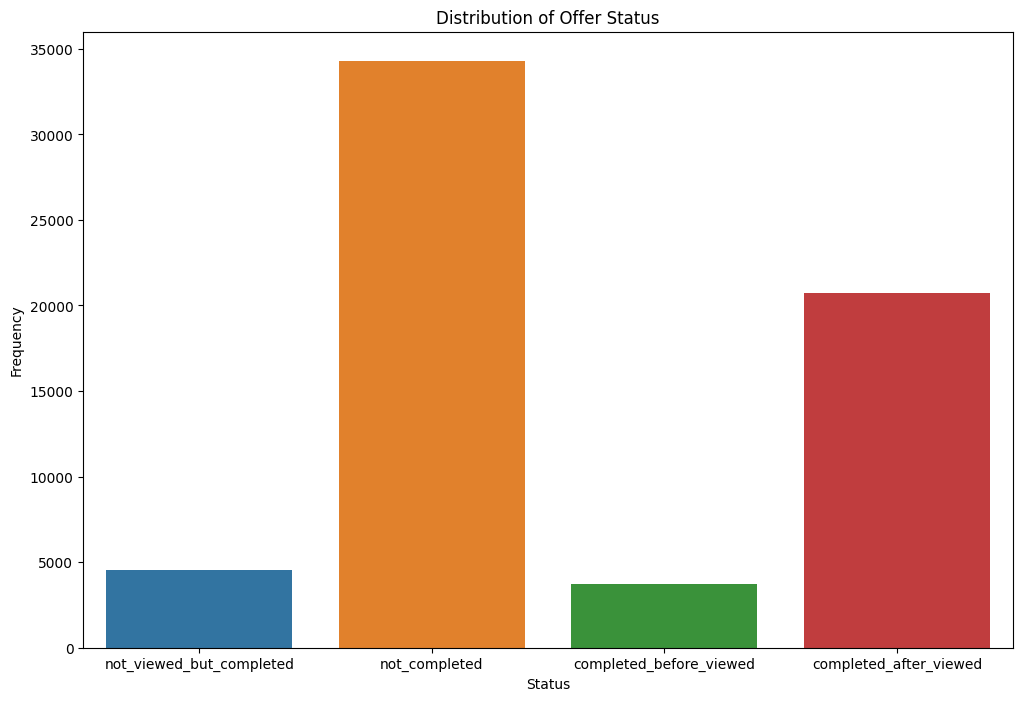

In [155]:
plt.figure(figsize=(12,8))
ax = sns.countplot(completion_details_df, x='status');
ax.set(title='Distribution of Offer Status', xlabel='Status', ylabel='Frequency');

- The 'not_completed' status includes the offers which were received, as well as those that were received and viewed. Most of the offer statuses fall into this category (54%)
- 33% of offers had a status of 'completed_after_viewed' which is the 'ideal' completion trail of the offer being received, then viewed, the completed. This was the second most common offer status and had 20,752 offers falling into this category.
- 13% were offers fell into the last two categories of 'not_viewed_but_completed' and 'not_completed' i.e. they were completed and either not viewed or viewed afterwards.
- 28,996 offers were utilised.
- 11,568 customers completed an offer after viewing it, and 3,233 people completed offers before viewing them.

*This answers our second question about how many customers complete offers before and after viewing them. 11,568 customers completed an offer after viewing it, and 3,233 customers completed the offer first before viewing it. Over half of the offers that were sent were not completed.*

In [156]:
# merging the completed after viewing counts for each offer to the cleaned portfolio dataset
completed_offers = pd.DataFrame(completion_details_df[completion_details_df['status'] == 'completed_after_viewed']['offer_id'].value_counts()).reset_index()
pd.merge(completed_offers, portfolio_clean, on='offer_id', how='left')

,offer_id,count,reward,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,fafdcd668e3743c1bb461111dcafc2a4,4033,2,10,10,discount,1,1,1,1,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3820,3,7,7,discount,1,1,1,1,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,3129,5,5,5,bogo,1,1,1,1,1,0,0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,2436,10,10,5,bogo,1,1,1,1,1,0,0
4,ae264e3637204a6fb9bb56bc8210ddfd,2314,10,10,7,bogo,1,1,1,0,1,0,0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1922,5,5,7,bogo,1,1,0,1,1,0,0
6,2906b810c7d4411798c6938adc9daaa5,1891,2,10,7,discount,1,1,0,1,0,1,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1207,5,20,10,discount,1,0,0,1,0,1,0


In [157]:
pd.merge(completed_offers, portfolio_clean, on='offer_id', how='left').groupby('offer_type')['count'].sum()

offer_type
bogo         9801
discount    10951
Name: count, dtype: int64

*This answers our third question about the offer type that was most likely to be completed. Surprisingly, it appears that discount offers are both the most common and least common type of offer to be completed after viewed, even with the same durations and similar reward/difficulty. Overall though, discount offers were the most likely type of offer to be completed after being viewed, with 1,150 more discount offers being completed after being viewed than bogo offers.*

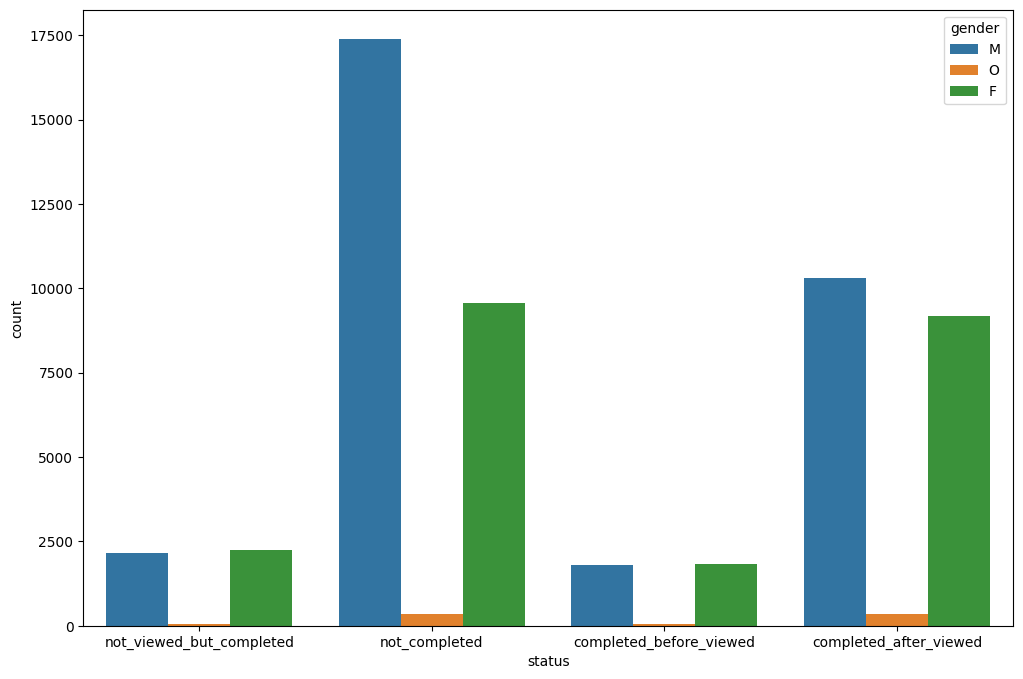

In [158]:
plt.figure(figsize=(12,8))
sns.countplot(pd.merge(completion_details_df, profile_clean[['customer_id','gender']], on='customer_id', how='left'), x = 'status', hue='gender')
ax.set(title='Distribution of Offer Status by Gender', xlabel='Status', ylabel='Frequency');

This final graph above is very interesting as we see the difference between male and females for each offer status is largest for the offers that were not completed. A lot more men than women didn't complete offers, whereas for the 'ideal' completion track of completion_after_viewed, the difference between the two is a lot smaller.

## Data Modelling

Now that problem questions 1-3 have been answered through exploratory analysis with visualisations and descriptive statistics, we will move onto answering the fourth and final question of understanding which attributes in the dataset most contribute to a customer's likelihood of completing an offer after viewing it. We will do this by building a machine learning pipeline that uses cross-validation and also has optimised hyperparameters to select the model with the highest accuracy score.

### Feature Engineering

First we need to create the dataframe that would have our X matrix of features and Y response variable to be used in the model.

In [159]:
model_df = completion_details_df.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63288 entries, 0 to 63287
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   status       63288 non-null  object
 1   customer_id  63288 non-null  object
 2   offer_id     63288 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [160]:
model_df['completed_after_viewed'] = pd.get_dummies(model_df['status']).groupby(level=0).sum().drop(columns=['not_viewed_but_completed','not_completed','completed_before_viewed'])

In [161]:
model_df = pd.merge(model_df, portfolio_clean, on='offer_id', how='left')
model_df = pd.merge(model_df, profile_clean.drop(columns=['gender','became_member_on']), on='customer_id', how='left')
model_df = pd.merge(model_df, transaction_plot_df.drop(columns=['gender']).rename(columns={'amount':'transaction_amount', 'count':'transaction_count'}), on='customer_id', how='left')
model_df.drop(columns=['status','customer_id','offer_id','offer_type','membership_year'], inplace=True)

In [162]:
model_df = model_df.dropna(axis=0)
model_df.head(10)

,completed_after_viewed,reward,difficulty,duration,email,mobile,social,web,bogo,discount,...,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,transaction_amount,transaction_count
0,0,2,10,7,1,1,0,1,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,127.60,8.0
1,0,0,0,4,1,1,0,1,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,127.60,8.0
2,0,0,0,3,1,1,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,127.60,8.0
3,0,5,5,5,1,1,1,1,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,127.60,8.0
4,0,2,10,10,1,1,1,1,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,127.60,8.0
6,1,5,20,10,1,0,0,1,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,79.46,5.0
7,1,3,7,7,1,1,1,1,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,79.46,5.0
8,0,0,0,4,1,1,0,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,79.46,5.0
9,0,0,0,3,1,1,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,79.46,5.0
10,1,5,5,7,1,1,0,1,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,79.46,5.0


### Modelling

In order to build a predictive model to be able to predict whether an offer will be completed after being viewed, we will first normalise the data, determine which classifier gives a higher accuracy score, and then use SelectKBest to select the features that produce the best accuracy score. The data first needs to be split into train and test sets.

In [164]:
Y = model_df['completed_after_viewed']
X = model_df.drop(columns='completed_after_viewed')

In [165]:
# checking for any missing data in the features
X.isna().sum()

reward                   0
difficulty               0
duration                 0
email                    0
mobile                   0
social                   0
web                      0
bogo                     0
discount                 0
informational            0
age                      0
income                   0
customer_loyalty_days    0
gender_F                 0
gender_M                 0
gender_O                 0
year_joined_2013         0
year_joined_2014         0
year_joined_2015         0
year_joined_2016         0
year_joined_2017         0
year_joined_2018         0
transaction_amount       0
transaction_count        0
dtype: int64

In [166]:
X.describe()

,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,...,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,transaction_amount,transaction_count
count,53987.000000,53987.000000,53987.000000,53987.0,53987.000000,53987.000000,53987.000000,53987.000000,53987.000000,53987.000000,...,53987.000000,53987.000000,53987.000000,53987.000000,53987.000000,53987.000000,53987.000000,53987.000000,53987.000000,53987.000000
mean,4.206346,7.713801,6.506085,1.0,0.899031,0.599811,0.798933,0.399763,0.400096,0.200141,...,0.573064,0.013651,0.018838,0.045585,0.108841,0.207068,0.377461,0.242206,121.906929,8.715469
std,3.404103,5.545905,2.205351,0.0,0.301290,0.489941,0.400802,0.489854,0.489922,0.400109,...,0.494637,0.116040,0.135953,0.208585,0.311443,0.405209,0.484756,0.428423,131.904318,5.159581
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,1.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.010000,5.000000
50%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.680000,8.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,166.520000,12.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1608.690000,36.000000


In [167]:
# email column only has '1' values in it therefore will provide no extra benefit for the model
X.drop(columns=['email'], inplace=True)

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37790, 23), (16197, 23), (37790,), (16197,))

In [169]:
# normalising the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [227]:
Y.mean()

0.36742178672643416

As this is a classification problem, we will use an f1 score as the metric of choice instead of an accuracy score. The f1 score is more accurate than an accuracy score when there is uneven class distribution present. We have this situation here as only 36% of the response variable is the true value.

This is the metric we optimize, since the f1 score is a way to take into account both precision and recall and therefore the metric that compensantes and optimised the full picture.

We perform a comparision of three classifiers and perform hyperparamter tuning for them to oprtimize for the best f1 score. 
Firt we will not tune the hyperparameters but use the default values in order to get the classifier with the best score and then we will perform hyperparameter tuning over this classifier to optimize computational efforts.

#### Finding the Best Classifier

In [170]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train,y_train)

y_pred = baseline_model.predict(X_test)
accuracy = f1_score(y_test, y_pred)
accuracy

0.6715392743923917

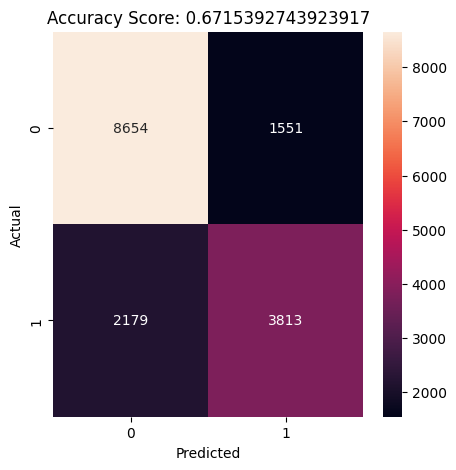

In [171]:
# plot confusion matrix

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d");
plt.ylabel('Actual');
plt.xlabel('Predicted');
plt.title('Accuracy Score: {}'.format(f1_score(y_test, y_pred)));
plt.show() 

In [172]:
baseline_model_2 = SVC()
baseline_model_2.fit(X_train,y_train)

y_pred_2 = baseline_model_2.predict(X_test)
accuracy_2 = f1_score(y_test, y_pred_2)
accuracy_2

0.70342405618964

In [173]:
baseline_model_3 = DecisionTreeClassifier()
baseline_model_3.fit(X_train,y_train)

y_pred_3 = baseline_model_3.predict(X_test)
accuracy_3 = f1_score(y_test, y_pred_3)
accuracy_3

0.6423885618166526

In [ ]:
metrics_df = pd.DataFrame({'model':['Logistic Regression', 'SVC', 'Decision Tree'],'metrics':[accuracy, accuracy_2, accuracy_3]})

SVC seems to give the highest f1 score = 70.3%, and this is on the full set of features in X i.e. 23 variables. We will ise this classifier and try improvements on the model by using GridSearch to find the optimal hyperparameters that optimise the f1 score for the model.

#### Optimising the Model

In [174]:
# Create pipeline
pipeline = make_pipeline(RobustScaler(),
                         SelectKBest(f_classif),
                         SVC())

In [175]:
# Model validation
param_grid = {
    'selectkbest__k': [3, 4, 5, 6, 7],
    'svc__class_weight': [None,'balanced'],
    'svc__C': [.0001, .001, .01, .1]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='f1', verbose=2)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=None; total time= 1.4min
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=None; total time= 1.4min
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=None; total time= 1.4min
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=None; total time= 1.4min
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=None; total time=  31.8s
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=balanced; total time=  57.8s
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=balanced; total time=  42.5s
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=balanced; total time=  43.4s
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=balanced; total time=  42.7s
[CV] END selectkbest__k=3, svc__C=0.0001, svc__class_weight=balanced; total time=  42.6s
[CV] END selectkbest__k=3, svc__C=0.001, svc__class_weight=None; tot

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('svc', SVC())]),
             param_grid={'selectkbest__k': [3, 4, 5, 6, 7],
                         'svc__C': [0.0001, 0.001, 0.01, 0.1],
                         'svc__class_weight': [None, 'balanced']},
             scoring='f1', verbose=2)

In [238]:
# Interpret the results

# Best cross validation score
print('Cross Validation Score:', grid.best_score_)

# Best parameters which resulted in the best score
print('Best Parameters:', grid.best_params_)

# Which features were selected?
selector = grid.best_estimator_.named_steps['selectkbest']
all_names = X.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Cross Validation Score: 0.7247384145466906
Best Parameters: {'selectkbest__k': 7, 'svc__C': 0.1, 'svc__class_weight': 'balanced'}
Features selected:
reward
duration
social
discount
informational
transaction_amount
transaction_count

Features not selected:
difficulty
mobile
web
bogo
age
income
customer_loyalty_days
gender_F
gender_M
gender_O
year_joined_2013
year_joined_2014
year_joined_2015
year_joined_2016
year_joined_2017
year_joined_2018


In [245]:
pd.DataFrame({'feature_name':list(X.columns),
              'feature_selected':grid.best_estimator_.named_steps['selectkbest'].get_support(),
              'feature_importance_score':grid.best_estimator_.named_steps['selectkbest'].scores_
}).sort_values(by='feature_importance_score', ascending=False).head(15)

,feature_name,feature_selected,feature_importance_score
8,informational,True,6379.455913
4,social,True,2386.538533
2,duration,True,2314.124561
21,transaction_amount,True,2182.030472
7,discount,True,1352.504172
0,reward,True,1189.828036
22,transaction_count,True,1167.321254
5,web,False,1002.494655
1,difficulty,False,927.965593
20,year_joined_2018,False,703.406414


In [177]:
#Get the best model and check it against test data set.

# Predict with X_test features
y_pred_grid = grid.predict(X_test)

# Compare predictions to y_test
f1_score(y_test, y_pred_grid)

0.7344398340248964

In [181]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80     10205
           1       0.64      0.86      0.73      5992

    accuracy                           0.77     16197
   macro avg       0.77      0.79      0.77     16197
weighted avg       0.80      0.77      0.77     16197



Through starting to optimise the 3 hyperparamters, GridSearch found that the best model with the highest f1 score of 73% had 7 features and a regulization parameter of 0.1. It also found that the 7 features that best predicted the completed after viewing status were: reward, duration of the offer, if the offer was communicated via social channels, the type of offer, the customer's total transactional amount and their count of transactions. 

Surprisingly gender is not so important although we did see previously a link between that and the customer's transactional amount and count, therefore it seems that these two features were selected over gender.

*This answers our fourth question of what attributes most contribute to a customer's likelihood of completing an offer after viewing it.*

In [234]:
11568/len(profile_clean['customer_id'].unique())

0.7803035413153457

## Conclusion

Throughout this notebook we performed exploratory data analysis and modelling to answer four questions that we set out to explore with the Starbucks Transactions dataset.

1. Gender does influence how much a person spends at Starbucks. While the average number of purchases made by men and women were even, women tend to spend more than men. On average, women spend around $6 more per purchase at Starbucks.

2. A significant portion of members do view and complete offers at Starbucks. Based on the dataset, 11,568 customers received, viewed, and completed the offers by making purchases associated with the offer - approximately 78%. Furthermore, 3,233 customers complete offers without actually viewing them first, therefore completing them unintentionally. We also saw that over half of the offers that were sent were not completed.

3. Discount offers were the most likely type of offer to be completed after being viewed, with 1,150 more discount offers being completed after being viewed than bogo offers.

4. The attributes that most contribute to the likelihood of a customer completeing an offer after viewing it are if the offer was an informational type, if it was communicated via social channels, the offer duration, and the customer's total transactional amount.

These are very interesting findings, and with the data we cleaned and processed, we can use them to look at many other trends.